In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qr-code/Second Print/input_image_bubble (4).png
/kaggle/input/qr-code/Second Print/input_image_branch.png
/kaggle/input/qr-code/Second Print/input_image_branch (2).png
/kaggle/input/qr-code/Second Print/input_image_create (5).png
/kaggle/input/qr-code/Second Print/input_image_active (5).png
/kaggle/input/qr-code/Second Print/input_image_canvas.png
/kaggle/input/qr-code/Second Print/input_image_assume(1).png
/kaggle/input/qr-code/Second Print/input_image_avenue (3).png
/kaggle/input/qr-code/Second Print/input_image_carbon (3).png
/kaggle/input/qr-code/Second Print/input_image_bubble (2).png
/kaggle/input/qr-code/Second Print/input_image_occupy (4).png
/kaggle/input/qr-code/Second Print/input_image_belong (2).png
/kaggle/input/qr-code/Second Print/input_image_occupy (5).png
/kaggle/input/qr-code/Second Print/input_image_nuance(2).png
/kaggle/input/qr-code/Second Print/input_image_nuance (3).png
/kaggle/input/qr-code/Second Print/input_image_canvas(1).png
/kaggle/input/qr-co

In [60]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [61]:
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [62]:
first_print_path = '/kaggle/input/qr-code/First Print'
second_print_path = '/kaggle/input/qr-code/Second Print'

In [63]:
first_print_images, first_print_labels = load_images_from_folder(first_print_path, 0)
second_print_images, second_print_labels = load_images_from_folder(second_print_path, 1)


In [64]:
# Combine data
X = np.concatenate((first_print_images, second_print_images), axis=0)
y = np.concatenate((first_print_labels, second_print_labels), axis=0)


In [65]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [66]:
def extract_hog_features(images):
    features = []
    for img in images:
        hog_feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        features.append(hog_feature)
    return np.array(features)

In [67]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)


In [68]:
# Train SVM Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_hog, y_train)

# Predict with SVM
y_pred_svm = svm_model.predict(X_test_hog)

SVM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



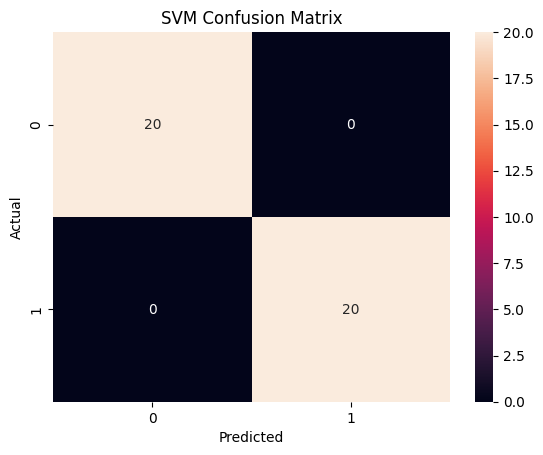

In [69]:
# Evaluate SVM Model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d')
plt.title("SVM Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
# Stratified K-Fold Validation for SVM
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_train_hog, y_train, cv=cv, scoring='accuracy')
print(f"Mean SVM Accuracy (5-Fold CV): {np.mean(scores):.4f}")

Mean SVM Accuracy (5-Fold CV): 1.0000


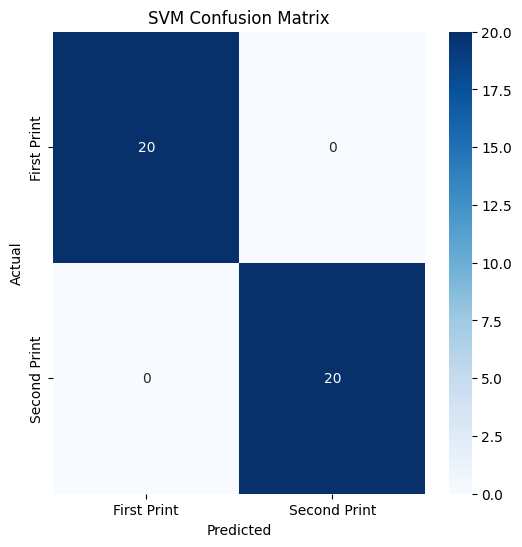

In [71]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['First Print', 'Second Print'], yticklabels=['First Print', 'Second Print'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

In [79]:
# Deep Learning Model - CNN
X_train_cnn = X_train.reshape(-1, 128, 128, 1) / 255.0
X_test_cnn = X_test.reshape(-1, 128, 128, 1) / 255.0

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [80]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5677 - loss: 1.0850 - val_accuracy: 0.6875 - val_loss: 0.5951
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5906 - loss: 0.7579 - val_accuracy: 0.3750 - val_loss: 0.7040
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 0.6763 - val_accuracy: 0.6250 - val_loss: 0.5973
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6948 - loss: 0.6057 - val_accuracy: 0.8750 - val_loss: 0.5863
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8427 - loss: 0.5154 - val_accuracy: 0.8125 - val_loss: 0.4541
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8583 - loss: 0.3745 - val_accuracy: 0.8125 - val_loss: 0.4288
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8479 - loss: 0.3490 - val_accuracy: 0.9375 - val_loss: 0.3156
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9021 - loss: 0.2719 - val_accuracy: 0.8750 - val_loss: 0.2895

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
CNN Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



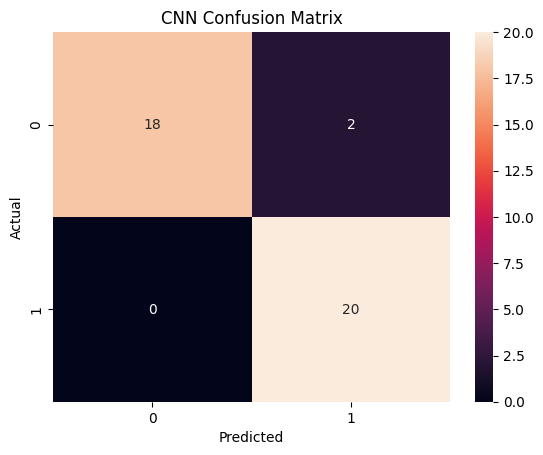

In [81]:
# Evaluate CNN Model
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
print("CNN Accuracy:", accuracy_score(y_test, y_pred_cnn))
print(classification_report(y_test, y_pred_cnn))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d')
plt.title("CNN Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()